In [3]:
import plotly
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import seaborn as sns
from time import time
import lightgbm as lgb
from sklearn import tree
from pprint import pprint
from pprint import pprint
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
plotly.offline.init_notebook_mode(connected=True)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge,LinearRegression, Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, accuracy_score,mean_squared_error,recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor,AdaBoostClassifier
from sklearn.metrics import confusion_matrix,f1_score,roc_curve,auc,mean_absolute_error,precision_score, r2_score
warnings.filterwarnings('ignore')

In [4]:
# Importing data from Amazon S3 Bucket
from smart_open import smart_open
import boto3,os,sys
bucket = "tirth-pipalia-dissertation"
file_name = "Dissetation.csv"

s3 = boto3.client('s3')
# 's3' is a key word. create connection to S3 using default config and all buckets within S3

obj = s3.get_object(Bucket= bucket, Key= file_name)
S3_data = pd.read_csv(obj['Body']) 


In [3]:
dataset=S3_data.copy()

In [4]:
print(dataset.dtypes)

Type                              object
Days for shipping (real)           int64
Days for shipment (scheduled)      int64
Benefit per order                float64
Sales per customer               float64
Delivery Status                   object
Late_delivery_risk                 int64
Category Id                        int64
Category Name                     object
Customer City                     object
Customer Country                  object
Customer Email                    object
Customer Fname                    object
Customer Id                        int64
Customer Lname                    object
Customer Password                 object
Customer Segment                  object
Customer State                    object
Customer Street                   object
Customer Zipcode                 float64
Department Id                      int64
Department Name                   object
Latitude                         float64
Longitude                        float64
Market          

In [5]:
# Creating explicit features from actual dataset
dataset['TotalPrice'] = dataset['Order Item Quantity'] * dataset['Order Item Total']
dataset['fraud'] = np.where(dataset['Order Status'] == 'SUSPECTED_FRAUD', 1, 0)
dataset['Customer Full Name'] = dataset['Customer Fname'].astype(str)+" "+ dataset['Customer Lname'].astype(str)
dataset['late_delivery']=np.where(dataset['Delivery Status'] == 'Late delivery', 1, 0)

In [6]:
dataset['Customer Zipcode']=dataset['Customer Zipcode'].fillna(0)

In [7]:
# Dropping the columns whihc are no useful for EDA, Classification and Regression
dataset=dataset.drop(['Product Status','Product Description'],axis=1)

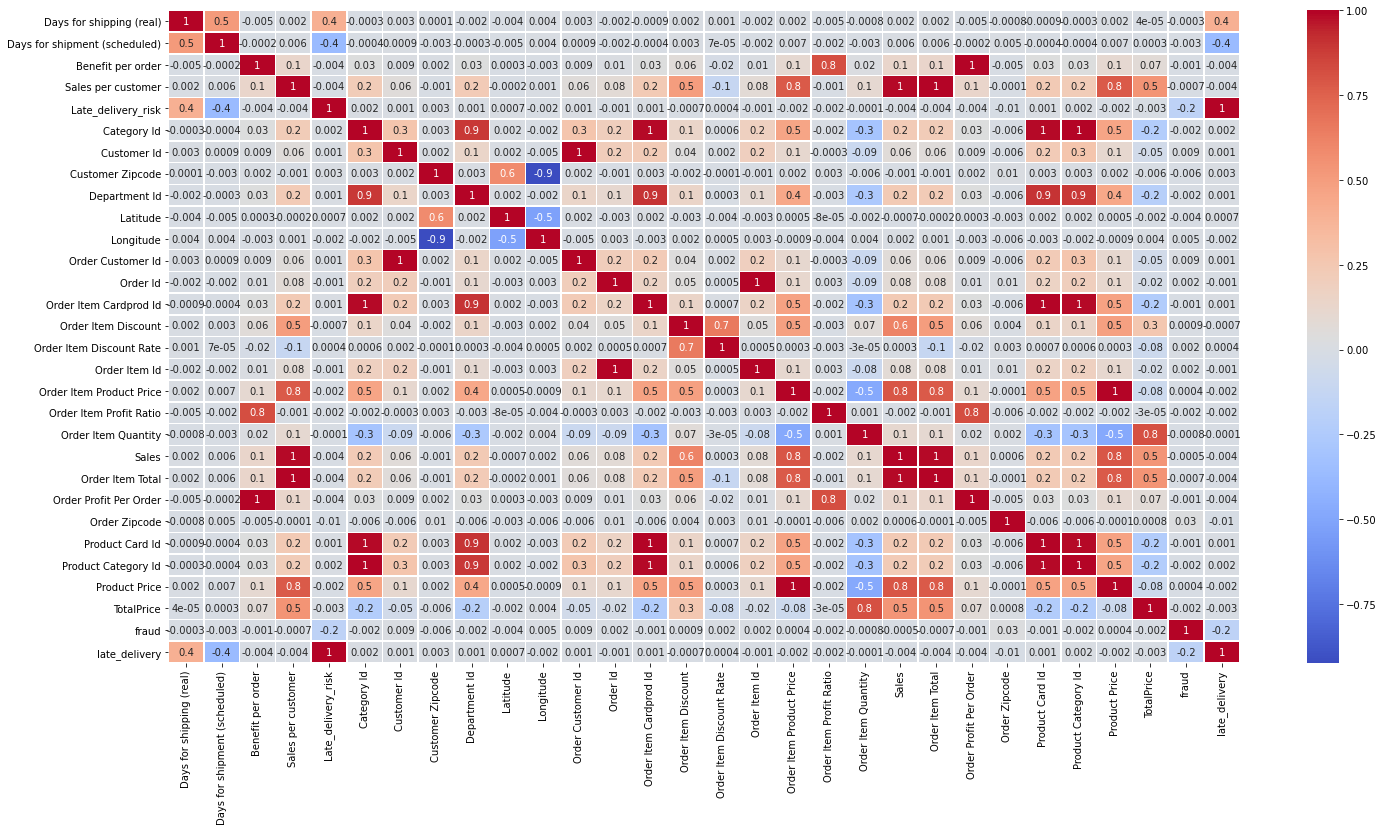

In [8]:
# Plotting Heat Map for checking co-relationship between features
fig, ax = plt.subplots(figsize=(24,12))
sns.heatmap(dataset.corr(),annot=True,linewidths=.5,fmt='.1g',cmap= 'coolwarm')

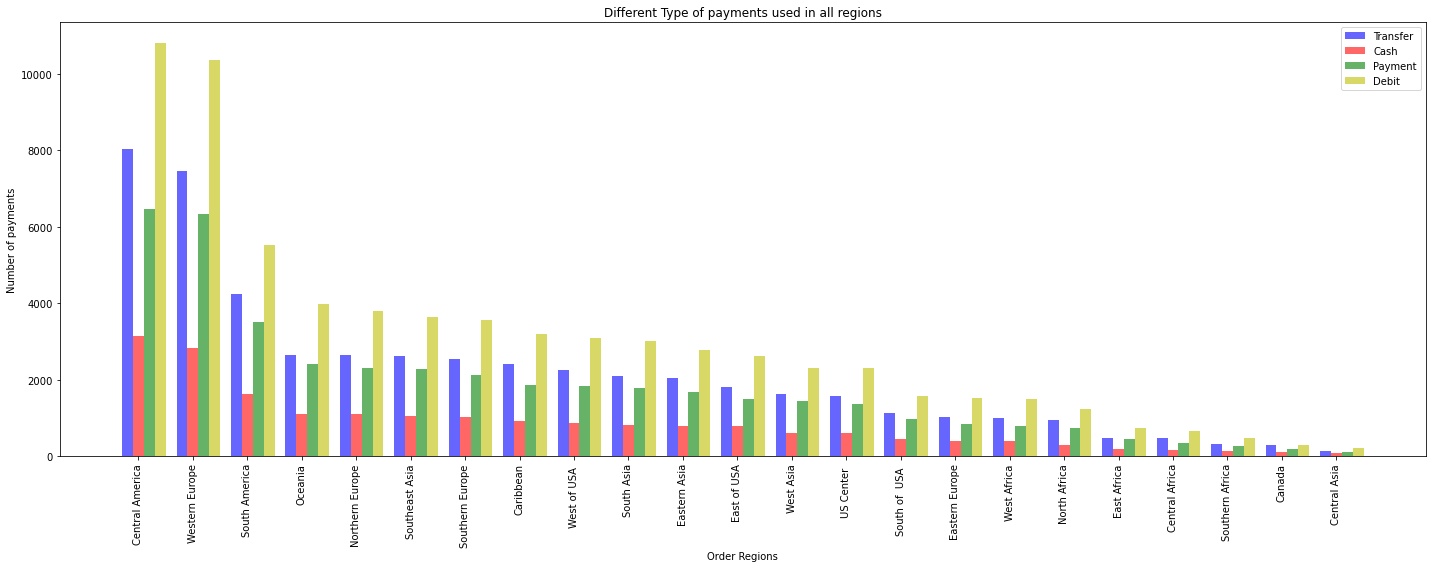

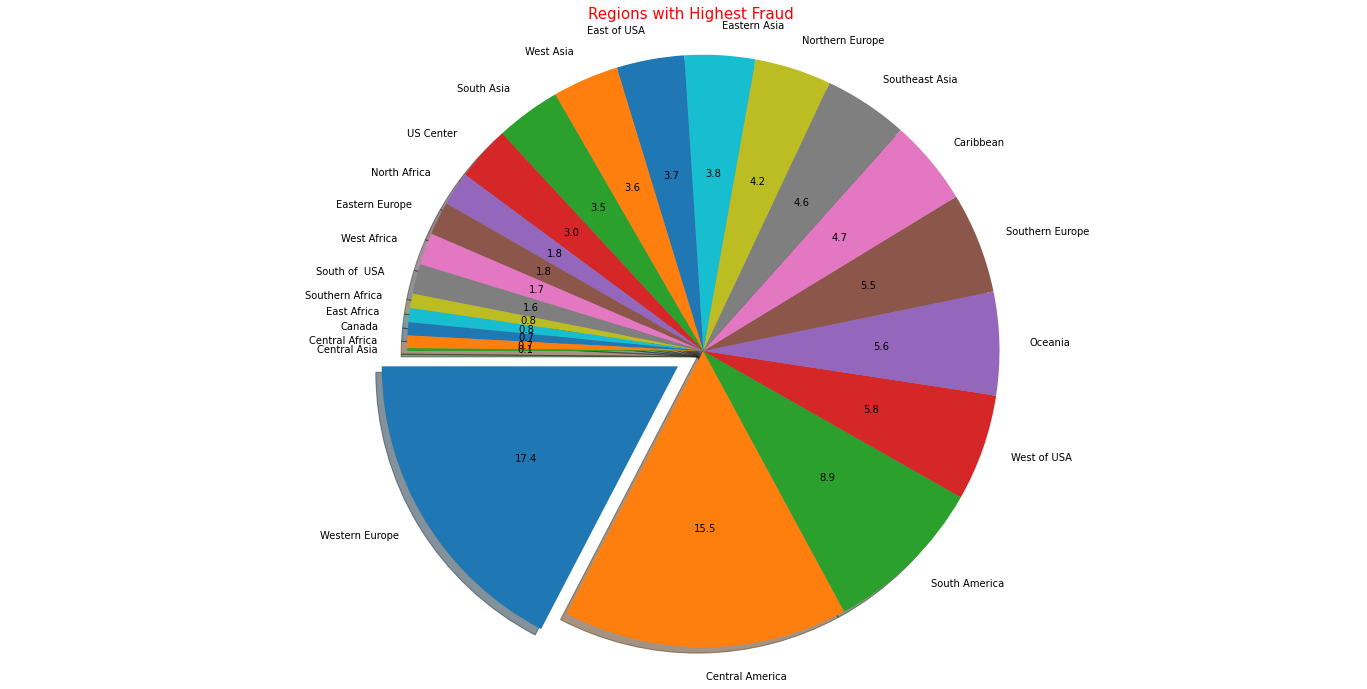

In [12]:
# EDA
x1 = dataset[(dataset['Type'] == 'TRANSFER')]
x2= dataset[(dataset['Type'] == 'CASH')]
x3= dataset[(dataset['Type'] == 'PAYMENT')]
x4= dataset[(dataset['Type'] == 'DEBIT')]
c1=x1['Order Region'].value_counts()
c2=x2['Order Region'].value_counts()
c3=x3['Order Region'].value_counts()
c4=x4['Order Region'].value_counts()
names=dataset['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8))
index=np.arange(n_groups)
bar_width=0.2
opacity=0.6
t1=plt.bar(index,c1,bar_width,alpha=opacity,color='b',label='Transfer')
t2=plt.bar(index+bar_width,c2,bar_width,alpha=opacity,color='r',label='Cash')
t3=plt.bar(index+bar_width+bar_width,c3,bar_width,alpha=opacity,color='g',label='Payment')
t4=plt.bar(index+bar_width+bar_width+bar_width,c4,bar_width,alpha=opacity,color='y',label='Debit')
plt.xlabel('Order Regions')
plt.ylabel('Number of payments')
plt.title('Different Type of payments used in all regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()

high_fraud = dataset[(dataset['Order Status'] == 'SUSPECTED_FRAUD') & (dataset['Type'] == 'TRANSFER')]#separating orders with suspected fraud
#Plotting pie chart with respect to order region
fraud=high_fraud['Order Region'].value_counts().plot.pie(figsize=(24,12),
                                                  startangle=180, explode=(0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0),autopct='%.1f',shadow=True,)
plt.title("Regions with Highest Fraud",size=15,color='r') # Plotting title
plt.ylabel(" ")
fraud.axis('equal') 
plt.show()

Total revenue lost with orders -3883547.345768667


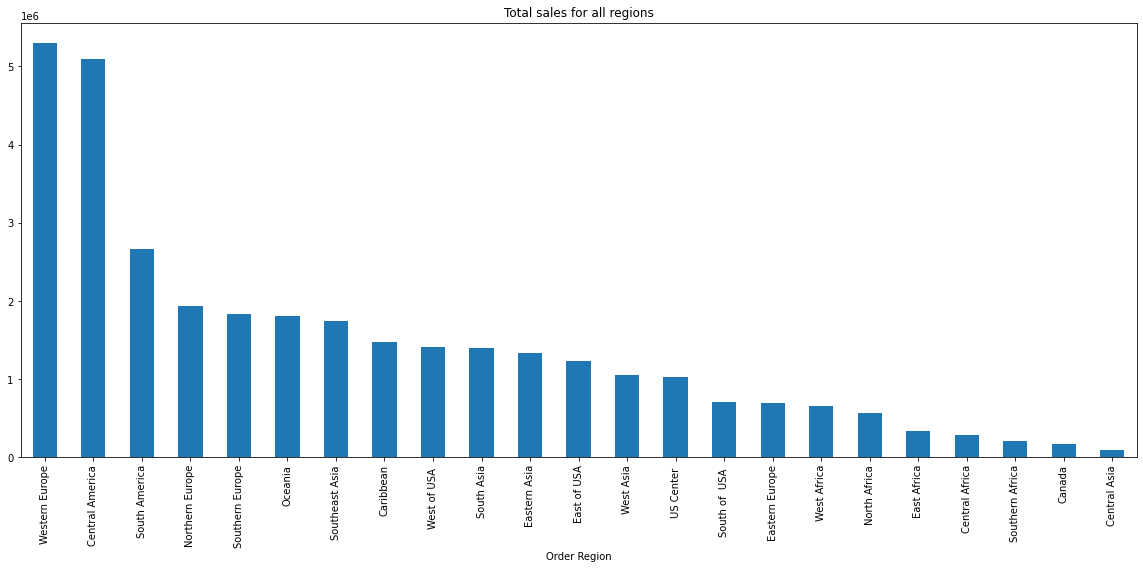

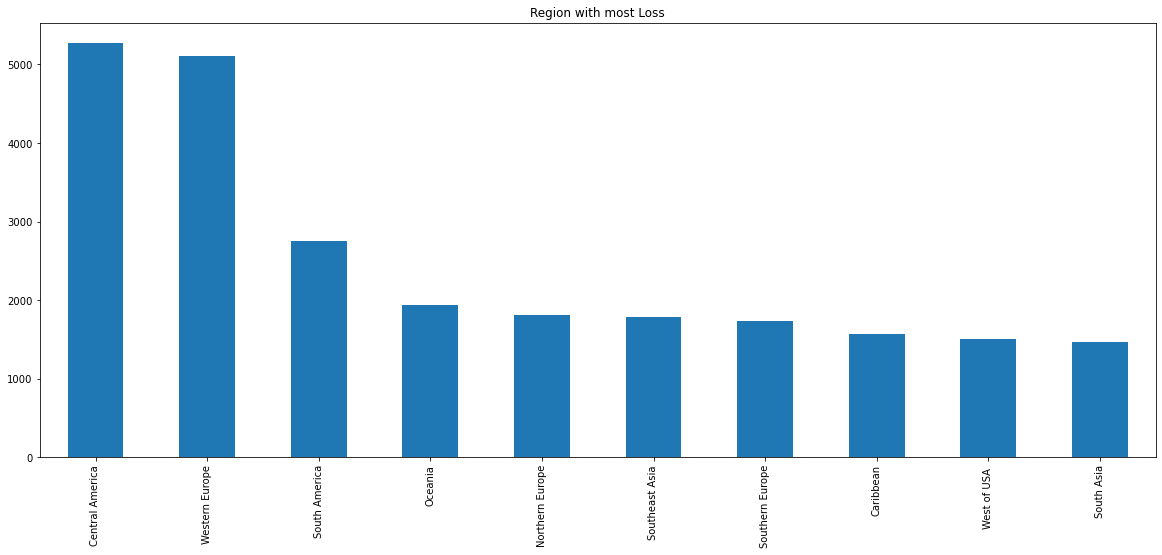

In [13]:
region = dataset.groupby('Order Region')
loss = dataset[(dataset['Benefit per order']<0)]
plt.figure(1)
region['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(20,8), title="Total sales for all regions")
plt.figure(2)
loss['Order Region'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Region with most Loss")
#Sum of total sales which are lost
print('Total revenue lost with orders',loss['Benefit per order'].sum())

# Classification Data Preparation

In [15]:
# Dropping features whihch are not useful for Classification due to high co-relationship and repitative descriptive data values
data=dataset.drop(['Customer Email','Customer Password','Customer Street','Customer Fname','Customer Lname','Benefit per order',
                   'Sales per customer','Category Id','Customer Country','Customer State','Customer Zipcode','Department Id',
                   'Market','Order Country','Order Customer Id','order date (DateOrders)','Order Item Cardprod Id',
                   'Order Item Discount Rate','Order Item Id','Order Item Product Price','Order Item Profit Ratio',
                   'Order Item Quantity','Order Item Total','Order Region','Order State','Order Status','Product Category Id',
                   'Product Card Id','Product Price','Delivery Status','Latitude','late_delivery','Customer Full Name',
                   'Longitude','Product Image','Order Zipcode','shipping date (DateOrders)'],axis=1)
data.shape

(180519, 18)

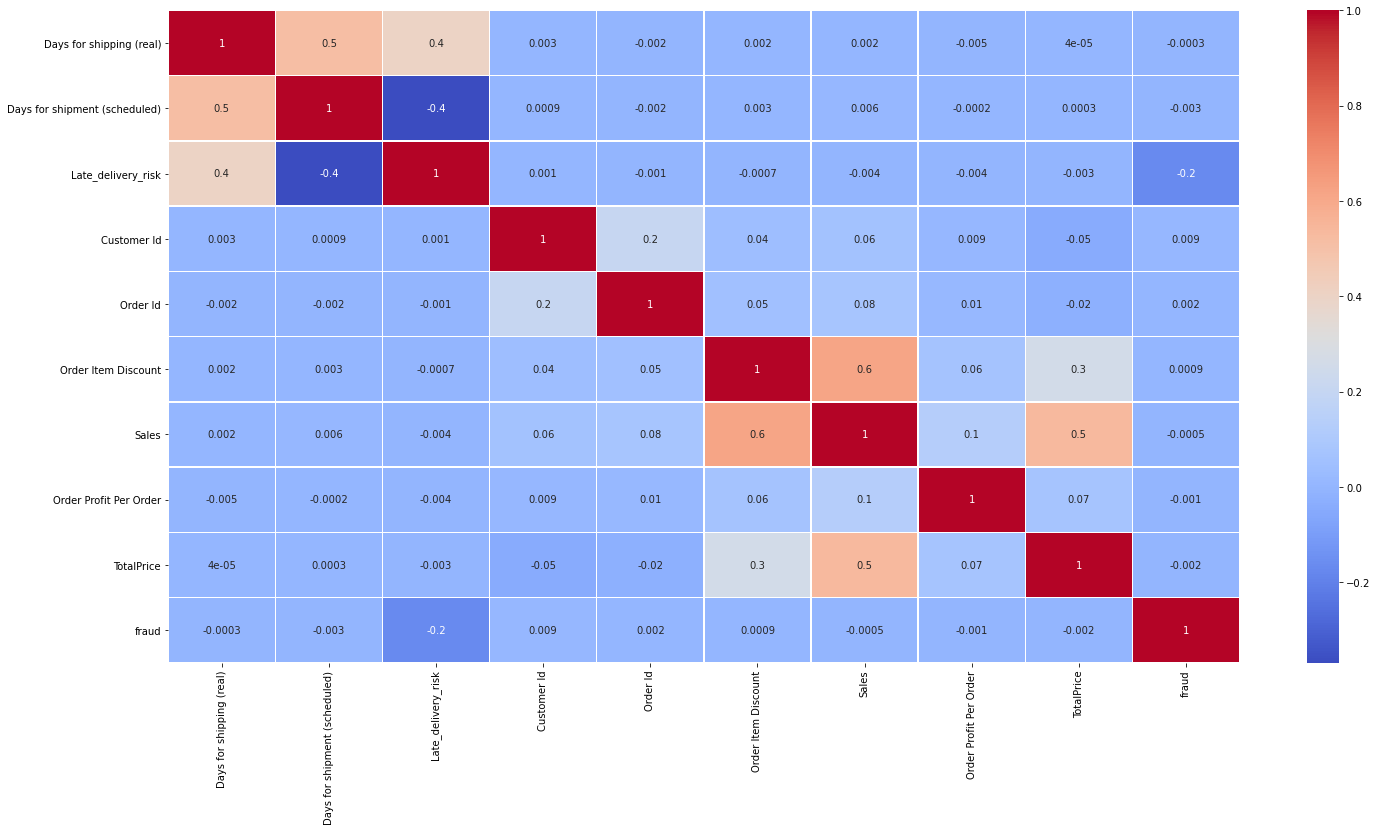

In [16]:
# Co-relation map after feature selection
fig, ax = plt.subplots(figsize=(24,12))
sns.heatmap(data.corr(),annot=True,linewidths=.5,fmt='.1g',cmap= 'coolwarm')

In [17]:
data.dtypes

Type                              object
Days for shipping (real)           int64
Days for shipment (scheduled)      int64
Late_delivery_risk                 int64
Category Name                     object
Customer City                     object
Customer Id                        int64
Customer Segment                  object
Department Name                   object
Order City                        object
Order Id                           int64
Order Item Discount              float64
Sales                            float64
Order Profit Per Order           float64
Product Name                      object
Shipping Mode                     object
TotalPrice                       float64
fraud                              int32
dtype: object

In [19]:
# Converting categorical features into numeric using LabelEncoder
le = preprocessing.LabelEncoder()
data['Type']              = le.fit_transform(data['Type'])
data['Product Name']      = le.fit_transform(data['Product Name'])
data['Customer Segment']  = le.fit_transform(data['Customer Segment'])
data['Category Name']     = le.fit_transform(data['Category Name'])
data['Customer City']     = le.fit_transform(data['Customer City'])
data['Department Name']   = le.fit_transform(data['Department Name'])
data['Shipping Mode']     = le.fit_transform(data['Shipping Mode'])
data['Order City']        = le.fit_transform(data['Order City'])



data.shape

(180519, 18)

In [20]:
data.head(5)

,Type,Days for shipping (real),Days for shipment (scheduled),Late_delivery_risk,Category Name,Customer City,Customer Id,Customer Segment,Department Name,Order City,Order Id,Order Item Discount,Sales,Order Profit Per Order,Product Name,Shipping Mode,TotalPrice,fraud
0,1,3,4,0,40,66,20755,0,4,331,77202,13.110000,327.75,91.250000,78,3,314.640015,0
1,3,5,4,1,40,66,19492,0,4,391,75939,16.389999,327.75,-249.089996,78,3,311.359985,0
2,0,4,4,0,40,452,19491,0,4,391,75938,18.030001,327.75,-247.779999,78,3,309.720001,0
3,1,3,4,0,40,285,19490,2,4,3226,75937,22.940001,327.75,22.860001,78,3,304.809998,0
4,2,2,4,0,40,66,19489,1,4,3226,75936,29.500000,327.75,134.210007,78,3,298.250000,0


In [21]:
# Assing target variable
x=data.loc[:, data.columns != 'fraud']# All the features except 'fraud'
y=data['fraud']                       # Only 'fraud' feature

# Splitting the data into training set=70% and test set=30%
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 42)

In [22]:
# Normalizing the data points so the average mean is 0 and Standard Deviation is 1

SSL = StandardScaler()
x_train=SSL.fit_transform(x_train)
x_test=SSL.transform(x_test)

In [23]:
from imblearn.over_sampling import SMOTE 

In [24]:
# Implementing Oversampling to balance the dataset; SMOTE stands for Synthetic Minority Oversampling TEchnique
print("Number of observations in each class before oversampling (training data): \n", pd.Series(y_train).value_counts())

Number of observations in each class before oversampling (training data): 
 0    123540
1      2823
Name: fraud, dtype: int64


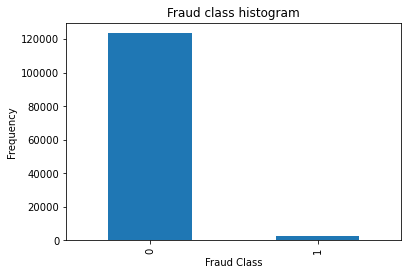

In [25]:
    pd.value_counts(pd.Series(y_train)).plot.bar()
    plt.title('Fraud class histogram')
    plt.xlabel('Fraud Class')
    plt.ylabel('Frequency')
    plt.show()

In [26]:
smote = SMOTE(random_state = 101)
x_train,y_train = smote.fit_sample(x_train,y_train)


In [27]:
print("Number of observations in each class before oversampling (training data): \n", pd.Series(y_train).value_counts())

Number of observations in each class before oversampling (training data): 
 1    123540
0    123540
Name: fraud, dtype: int64


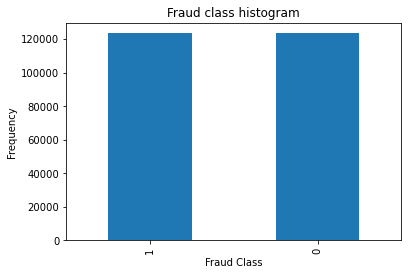

In [28]:
    pd.value_counts(pd.Series(y_train)).plot.bar()
    plt.title('Fraud class histogram')
    plt.xlabel('Fraud Class')
    plt.ylabel('Frequency')
    plt.show()

In [29]:
print("Number of observations in each class after oversampling (training data): \n", pd.Series(y_train).value_counts())

Number of observations in each class after oversampling (training data): 
 1    123540
0    123540
Name: fraud, dtype: int64


In [30]:
x_train.shape

(247080, 17)

# Decision Tree

In [31]:
# Parameter Tuning using RandomizedSearchCV for Decision Tree

criterion =['gini','entropy']
max_depth =[2,4,6,8]
max_features=['log2','auto','sqrt']
min_samples_split=[2,3,4,5,6,7,8,9,10]
min_samples_leaf=[2,3,4,5]
max_leaf_nodes=[2,3,4]
splitter =['best','random']
random_grid = {'criterion': criterion,
               'max_depth': max_depth,
               'max_features': max_features,
               'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
               'max_leaf_nodes':max_leaf_nodes,
               'splitter': splitter
               }
pprint(random_grid)
model = tree.DecisionTreeClassifier()
rf_random = RandomizedSearchCV(estimator=model,scoring='accuracy', param_distributions=random_grid, n_iter=50, cv=3,
                               verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(x_train, y_train)
print(rf_random.best_params_)
print(rf_random.best_estimator_)
print(rf_random.best_score_)

{'criterion': ['gini', 'entropy'],
 'max_depth': [2, 4, 6, 8],
 'max_features': ['log2', 'auto', 'sqrt'],
 'max_leaf_nodes': [2, 3, 4],
 'min_samples_leaf': [2, 3, 4, 5],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'splitter': ['best', 'random']}
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   14.5s finished


{'splitter': 'random', 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_leaf_nodes': 4, 'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'gini'}
DecisionTreeClassifier(max_depth=4, max_features='sqrt', max_leaf_nodes=4,
                       min_samples_leaf=4, min_samples_split=5,
                       splitter='random')
0.8705601424639792


Training time  : 0.27 s
Predicting time: 0.004 s
Model paramters used are : DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features='sqrt',
                       max_leaf_nodes=3, min_samples_leaf=3,
                       min_samples_split=7)
Accuracy: 85.82428539773986 %
Recall  : 8.443067389620449 %
F1      : 14.557595993322202 %
AUCROC  : 69.69119166517842 %
Confusion matrix:
TP:  654
TN:  45825
FP:  7092
FN:  585 

Type                             0.972181
Customer Segment                 0.027819
Days for shipping (real)         0.000000
Days for shipment (scheduled)    0.000000
Late_delivery_risk               0.000000
Category Name                    0.000000
Customer City                    0.000000
Customer Id                      0.000000
TotalPrice                       0.000000
Shipping Mode                    0.000000
Order City                       0.000000
Order Id                         0.000000
Order Item Discount              0.000000
Sales          

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

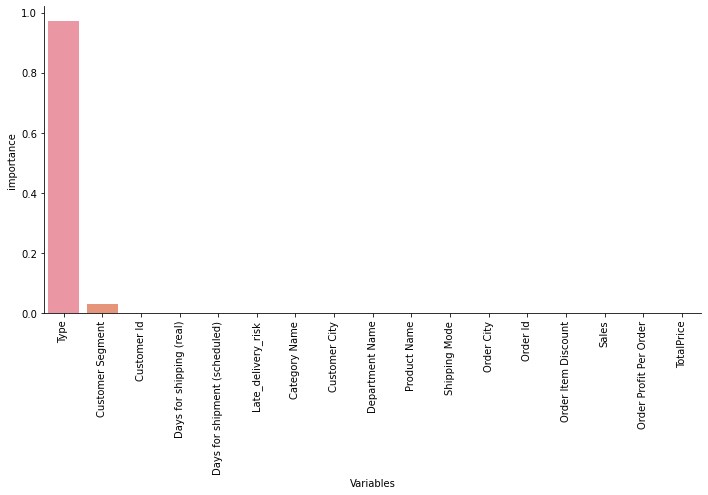

In [51]:
# Tuned Decision Tree Model

H_DT_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features='sqrt',
                       max_leaf_nodes=3, min_samples_leaf=3,
                       min_samples_split=7)
t0=time()
H_DT_model=H_DT_model.fit(x_train,y_train) # Fitting train data for fraud detection
print("Training time  :", round(time()-t0, 3), "s")
t1=time()
H_DT_y_pred=H_DT_model.predict(x_test)
print("Predicting time:",round(time()-t1,3),"s")
H_DT_accuracy=accuracy_score(H_DT_y_pred, y_test) #Accuracy for fraud detection
H_DT_recall=recall_score(H_DT_y_pred, y_test) #Recall score for  fraud detection
H_DT_conf=confusion_matrix(y_test, H_DT_y_pred)# fraud detection
H_DT_precision= precision_score(y_test, H_DT_y_pred)
H_DT_f1=f1_score(y_test, H_DT_y_pred)#fraud detection
H_DT_auc=roc_auc_score(y_test,H_DT_y_pred)
H_DT_fpr,H_DT_tpr, _ =roc_curve(y_test,H_DT_y_pred)
print('Model paramters used are :',H_DT_model)
print('Accuracy:', (H_DT_accuracy)*100,'%')
print('Recall  :', (H_DT_recall)*100,'%')
print('F1      :', (H_DT_f1)*100,'%')
print('AUCROC  :', (H_DT_auc)*100,'%')
print('Confusion matrix:')
print('TP: ', H_DT_conf[1, 1])
print('TN: ', H_DT_conf[0, 0])
print('FP: ', H_DT_conf[0, 1])
print('FN: ', H_DT_conf[1, 0],'\n')

# To print important features
featimp = pd.Series(H_DT_model.feature_importances_, index=list(x)).sort_values(ascending=False)
print(featimp)

# Vizulization of important features
important_col=H_DT_model.feature_importances_.argsort()
feat_imp=pd.DataFrame({'Variables':x.columns[important_col],'importance':H_DT_model.feature_importances_[important_col]})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='Variables', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)

Training time : 4.55 s
Predition time: 0.009 s
Model paramters used are : DecisionTreeClassifier()
Accuracy: 97.5699830120393 %
Recall  : 47.57403906742282 %
F1      : 53.432413305024774 %
AUCROC  : 79.68198267092954 %
Confusion matrix:
TP:  755
TN:  52085
FP:  484
FN:  832
Type                             0.588714
Late_delivery_risk               0.193944
Days for shipping (real)         0.046149
Customer Id                      0.023797
Order Id                         0.023037
Order City                       0.021920
Customer City                    0.019854
Customer Segment                 0.012963
Order Item Discount              0.012586
Shipping Mode                    0.010974
Order Profit Per Order           0.010946
TotalPrice                       0.009759
Product Name                     0.007215
Category Name                    0.006678
Sales                            0.006096
Department Name                  0.003678
Days for shipment (scheduled)    0.001690
dtype: floa

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

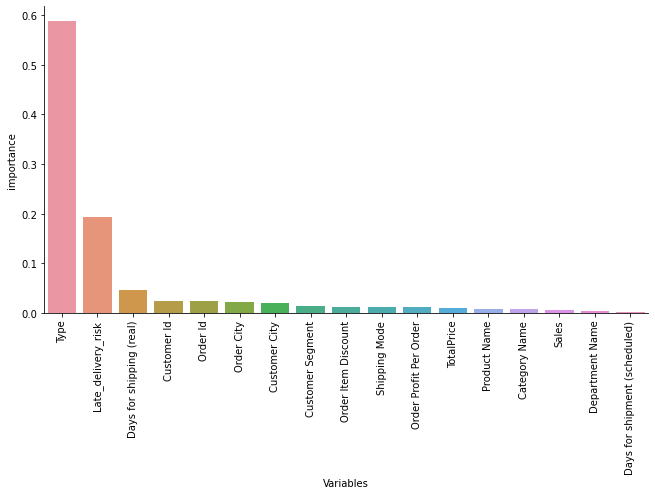

In [33]:
# Untuned Decision Tree Model

D_DT_model = tree.DecisionTreeClassifier()
t0=time()
D_DT_model=D_DT_model.fit(x_train,y_train) # Fitting train data for fraud detection
print("Training time :",round(time()-t0,3),"s")
t1=time()
D_DT_y_pred=D_DT_model.predict(x_test)
print("Predition time:",round(time()-t1,3),"s")
D_DT_accuracy=accuracy_score(D_DT_y_pred, y_test) #Accuracy for fraud detection
D_DT_recall=recall_score(D_DT_y_pred, y_test) #Recall score for  fraud detection
D_DT_conf=confusion_matrix(D_DT_y_pred, y_test)# fraud detection
D_DT_f1=f1_score(y_test, D_DT_y_pred)#fraud detection
D_DT_auc=roc_auc_score(y_test,D_DT_y_pred)
D_DT_fpr,D_DT_tpr, _ =roc_curve(y_test,D_DT_y_pred)
print('Model paramters used are :',D_DT_model)
print('Accuracy:', (D_DT_accuracy)*100,'%')
print('Recall  :', (D_DT_recall)*100,'%')
print('F1      :', (D_DT_f1)*100,'%')
print('AUCROC  :', (D_DT_auc)*100,'%')
print('Confusion matrix:')
print('TP: ', D_DT_conf[1, 1])
print('TN: ', D_DT_conf[0, 0])
print('FP: ', D_DT_conf[0, 1])
print('FN: ', D_DT_conf[1, 0])

# To print important features
featimp = pd.Series(D_DT_model.feature_importances_, index=list(x)).sort_values(ascending=False)
print(featimp)

# Vizulization of important features
important_col=D_DT_model.feature_importances_.argsort()
feat_imp=pd.DataFrame({'Variables':x.columns[important_col],'importance':D_DT_model.feature_importances_[important_col]})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='Variables', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)

# LightGBM

In [65]:
# Parameter Tuning using RandomizedSearchCV for Light GBM Model

max_depth = [int(x) for x in np.linspace(10, 50, num=11)]
max_depth.append(None)
num_leaves=[5,10,15,20,25,30]
boosting = ['gbdt','rf','dart','goss']
max_bin =[300,400,500,600]
objective=['binary']
n_estimators = [30, 40, 50, 60, 70, 80]
learning_rate = [0.002,0.003,0.004,0.005]
random_grid = {'max_bin' : max_bin,
               'learning_rate' : learning_rate,
               'n_estimators'  : n_estimators,
               'num_leaves'    : num_leaves,
               'max_depth'     : max_depth,
               'boosting'      : boosting,
               'objective'     : objective
               }
pprint(random_grid)
model = lgb.LGBMClassifier()
rf_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=50, cv=3,
                               verbose=2, n_jobs=-1)
rf_random.fit(x_train, y_train)
print(rf_random.best_params_)
print(rf_random.best_estimator_)
print(rf_random.best_score_)

{'boosting': ['gbdt', 'rf', 'dart', 'goss'],
 'learning_rate': [0.002, 0.003, 0.004, 0.005],
 'max_bin': [300, 400, 500, 600],
 'max_depth': [10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, None],
 'n_estimators': [30, 40, 50, 60, 70, 80],
 'num_leaves': [5, 10, 15, 20, 25, 30],
 'objective': ['binary']}
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.4min finished


Predicting time: 85.117 s
{'objective': 'binary', 'num_leaves': 30, 'n_estimators': 70, 'max_depth': 46, 'max_bin': 600, 'learning_rate': 0.005, 'boosting': 'gbdt'}
LGBMClassifier(boosting='gbdt', learning_rate=0.005, max_bin=600, max_depth=46,
               n_estimators=70, num_leaves=30, objective='binary')
0.9506677999028654


Training time  : 1.585 s
Prediction time: 0.055 s
Model paramters used are : LGBMClassifier(boosting='gbdt', learning_rate=0.004, max_bin=500, max_depth=22,
               n_estimators=50, num_leaves=30, objective='binary')
Accuracy: 91.87716965802495 %
Recall  : 20.511384845091452 %
F1      : 33.318174927997575 %
AUCROC  : 90.32605586683079 %
Confusion matrix:
TP:  1099
TN:  48658
FP:  4259
FN:  140 

Days for shipping (real)         350
Customer Id                      194
Order City                       184
Customer City                    113
Order Item Discount              109
Order Id                         101
Days for shipment (scheduled)    100
Customer Segment                  99
Type                              50
Late_delivery_risk                50
Shipping Mode                     50
Product Name                      39
Category Name                     11
TotalPrice                         0
Sales                              0
Order Profit Per Order             0
De

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

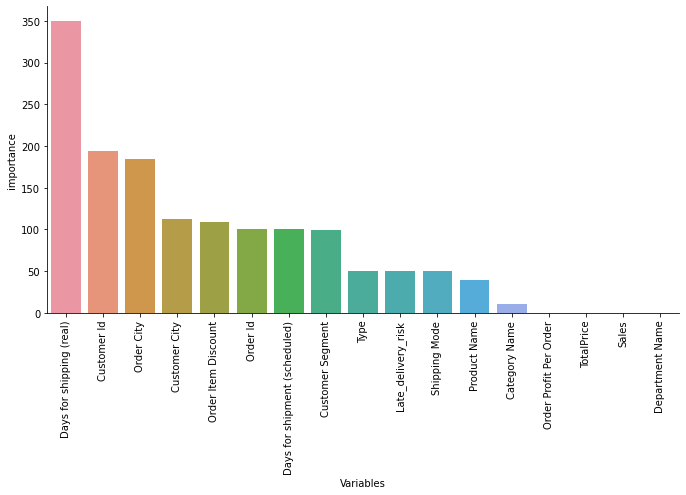

In [34]:
# Tuned LightGBM Model

H_LGBM_model = lgb.LGBMClassifier(boosting='gbdt', learning_rate=0.004, max_bin=500, max_depth=22,
               n_estimators=50, num_leaves=30, objective='binary')
t0=time()
H_LGBM_model=H_LGBM_model.fit(x_train,y_train) # Fitting train data for fraud detection
print("Training time  :", round(time()-t0, 3), "s")
t1=time()
H_LGBM_y_pred=H_LGBM_model.predict(x_test)
print("Prediction time:", round(time()-t1, 3), "s")
H_LGBM_accuracy=accuracy_score(H_LGBM_y_pred, y_test) #Accuracy for fraud detection
H_LGBM_recall=recall_score(H_LGBM_y_pred, y_test) #Recall score for  fraud detection
H_LGBM_conf=confusion_matrix(y_test, H_LGBM_y_pred)# fraud detection
H_LGBM_f1=f1_score(y_test, H_LGBM_y_pred)#fraud detection
H_LGBM_auc=roc_auc_score(y_test,H_LGBM_y_pred)
H_LGBM_fpr,H_LGBM_tpr, _ =roc_curve(y_test,H_LGBM_y_pred)
print('Model paramters used are :',H_LGBM_model)
print('Accuracy:', (H_LGBM_accuracy)*100,'%')
print('Recall  :', (H_LGBM_recall)*100,'%')
print('F1      :', (H_LGBM_f1)*100,'%')
print('AUCROC  :', (H_LGBM_auc)*100,'%')
print('Confusion matrix:')
print('TP: ', H_LGBM_conf[1, 1])
print('TN: ', H_LGBM_conf[0, 0])
print('FP: ', H_LGBM_conf[0, 1])
print('FN: ', H_LGBM_conf[1, 0],'\n')

# To print important features
featimp = pd.Series(H_LGBM_model.feature_importances_, index=list(x)).sort_values(ascending=False)
print(featimp)

# Vizulization of important features
important_col=H_LGBM_model.feature_importances_.argsort()
feat_imp=pd.DataFrame({'Variables':x.columns[important_col],'importance':H_LGBM_model.feature_importances_[important_col]})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='Variables', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)

Training time   : 2.116 s
Predicition time: 0.099 s
Model paramters used are : LGBMClassifier()
Accuracy: 95.97643843710762 %
Recall  : 32.720588235294116 %
F1      : 44.96084869916646 %
AUCROC  : 84.18693837363561 %
Confusion matrix:
TP:  890
TN:  51087
FP:  1830
FN:  349 

Order Item Discount              353
Days for shipping (real)         342
Customer City                    290
Sales                            247
Order City                       236
Order Id                         218
Customer Id                      214
Product Name                     180
TotalPrice                       172
Customer Segment                 162
Category Name                     97
Department Name                   97
Days for shipment (scheduled)     86
Order Profit Per Order            83
Type                              81
Shipping Mode                     71
Late_delivery_risk                71
dtype: int32


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

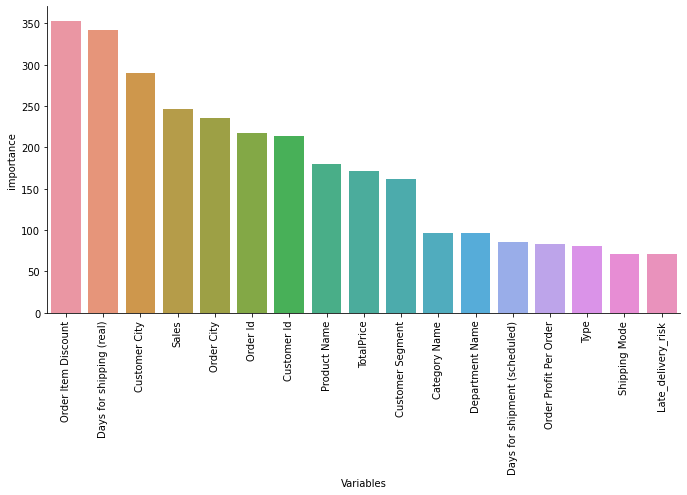

In [35]:
# Untuned LightGBM Model

D_LGBM_model = lgb.LGBMClassifier()
t0=time()
D_LGBM_model=D_LGBM_model.fit(x_train,y_train) # Fitting train data for fraud detection
print("Training time   :",round(time()-t0,3),"s")
t1=time()
D_LGBM_y_pred=D_LGBM_model.predict(x_test)
print("Predicition time:",round(time()-t1,3),"s")
D_LGBM_accuracy=accuracy_score(D_LGBM_y_pred, y_test) #Accuracy for fraud detection
D_LGBM_recall=recall_score(D_LGBM_y_pred, y_test) #Recall score for  fraud detection
D_LGBM_conf=confusion_matrix(y_test, D_LGBM_y_pred)# fraud detection
D_LGBM_f1=f1_score(y_test, D_LGBM_y_pred)#fraud detection
D_LGBM_auc=roc_auc_score(y_test,D_LGBM_y_pred)
D_LGBM_fpr,D_LGBM_tpr, _ =roc_curve(y_test,D_LGBM_y_pred)
print('Model paramters used are :',D_LGBM_model)
print('Accuracy:', (D_LGBM_accuracy)*100,'%')
print('Recall  :', (D_LGBM_recall)*100,'%')
print('F1      :', (D_LGBM_f1)*100,'%')
print('AUCROC  :', (D_LGBM_auc)*100,'%')
print('Confusion matrix:')
print('TP: ', D_LGBM_conf[1, 1])
print('TN: ', D_LGBM_conf[0, 0])
print('FP: ', D_LGBM_conf[0, 1])
print('FN: ', D_LGBM_conf[1, 0],'\n')
#to print important features
featimp = pd.Series(D_LGBM_model.feature_importances_, index=list(x)).sort_values(ascending=False)
print(featimp)
#vizulization of important features
important_col=D_LGBM_model.feature_importances_.argsort()
feat_imp=pd.DataFrame({'Variables':x.columns[important_col],'importance':D_LGBM_model.feature_importances_[important_col]})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='Variables', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)

# Random Forest Classifier

In [25]:
# Parameter Tuning using RandomizedSearchCV for Random Forest Model

n_estimators = [30, 40, 50, 60, 70, 80]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 50, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 3]
bootstrap = [True, False]
criterion = ['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
               }
pprint(random_grid)
rfc = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator=rfc, scoring='accuracy', param_distributions=random_grid, n_iter=50, cv=3,
                               verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(x_train, y_train)
print(rf_random.best_params_)
print(rf_random.best_estimator_)
print(rf_random.best_score_)


{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_depth': [10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [30, 40, 50, 60, 70, 80]}
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 17.8min finished


{'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}
RandomForestClassifier(bootstrap=False, max_features='sqrt',
                       min_samples_split=5, n_estimators=70, random_state=42)
0.9926542010684799


Training time  : 124.439 s
Prediciton time: 0.589 s
Model paramters used are : RandomForestClassifier(bootstrap=False, max_features='sqrt',
                       min_samples_split=5, n_estimators=70, random_state=42)
Accuracy: 98.33259472634612 %
Recall  : 65.96958174904944 %
F1      : 60.584897424705375 %
AUROC   : 77.66819123428755 %
Confusion matrix:
TP:  694
TN:  52559
FP:  358
FN:  545 


 Type                             0.451153
Late_delivery_risk               0.261989
Days for shipping (real)         0.070818
Customer City                    0.024105
Order Item Discount              0.022614
Order Id                         0.021713
Customer Id                      0.021240
Order City                       0.020617
Customer Segment                 0.015409
TotalPrice                       0.015105
Order Profit Per Order           0.013323
Shipping Mode                    0.012948
Days for shipment (scheduled)    0.012719
Sales                            0.011691
Product Name 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

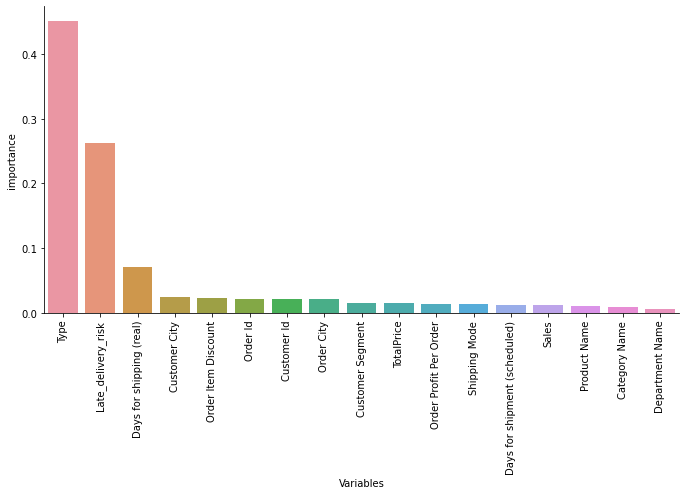

In [36]:
# Tuned Random Forest Model

H_RF_model = RandomForestClassifier(bootstrap=False, max_features='sqrt',
                       min_samples_split=5, n_estimators=70, random_state=42)
t0=time()
H_RF_model=H_RF_model.fit(x_train,y_train)
print("Training time  :",round(time()-t0,3),"s")
t1=time()
H_RF_y_pred=H_RF_model.predict(x_test)
print("Prediciton time:",round(time()-t1,3),"s")
H_RF_accuracy=accuracy_score(H_RF_y_pred, y_test) #Accuracy for fraud detection
H_RF_recall=recall_score(H_RF_y_pred, y_test) #Recall score for  fraud detection
H_RF_conf=confusion_matrix(y_test, H_RF_y_pred)# fraud detection
H_RF_f1=f1_score(y_test, H_RF_y_pred)#fraud detection
H_RF_auc=roc_auc_score(y_test,H_RF_y_pred)
H_RF_fpr,H_RF_tpr, _ =roc_curve(y_test,H_RF_y_pred)
print('Model paramters used are :',H_RF_model)
print('Accuracy:', (H_RF_accuracy)*100,'%')
print('Recall  :', (H_RF_recall)*100,'%')
print('F1      :', (H_RF_f1)*100,'%')
print('AUROC   :', (H_RF_auc)*100,'%')
print('Confusion matrix:')
print('TP: ', H_RF_conf[1, 1])
print('TN: ', H_RF_conf[0, 0])
print('FP: ', H_RF_conf[0, 1])
print('FN: ', H_RF_conf[1, 0],'\n')

# To print important features
featimp = pd.Series(H_RF_model.feature_importances_, index=list(x)).sort_values(ascending=False)
print('\n',featimp)

# Vizulization of important features
important_col=H_RF_model.feature_importances_.argsort()
feat_imp=pd.DataFrame({'Variables':x.columns[important_col],'importance':H_RF_model.feature_importances_[important_col]})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='Variables', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)


Training time  : 117.188 s
Prediction time: 0.805 s
Model paramters used are : RandomForestClassifier()
Accuracy: 98.14794297954059 %
Recall  : 59.577922077922075 %
F1      : 59.40914609469849 %
AUROC   : 79.15011360703254 %
Confusion matrix:
TP:  734
TN:  52419
FP:  498
FN:  505 


 Type                             0.434324
Late_delivery_risk               0.277036
Days for shipping (real)         0.067267
Order Item Discount              0.023447
Customer City                    0.022870
Customer Id                      0.021806
Order Id                         0.021657
Order City                       0.020899
Customer Segment                 0.018425
TotalPrice                       0.016514
Order Profit Per Order           0.014699
Shipping Mode                    0.014442
Sales                            0.011982
Product Name                     0.009865
Days for shipment (scheduled)    0.009643
Category Name                    0.008810
Department Name                  0.006313
d

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

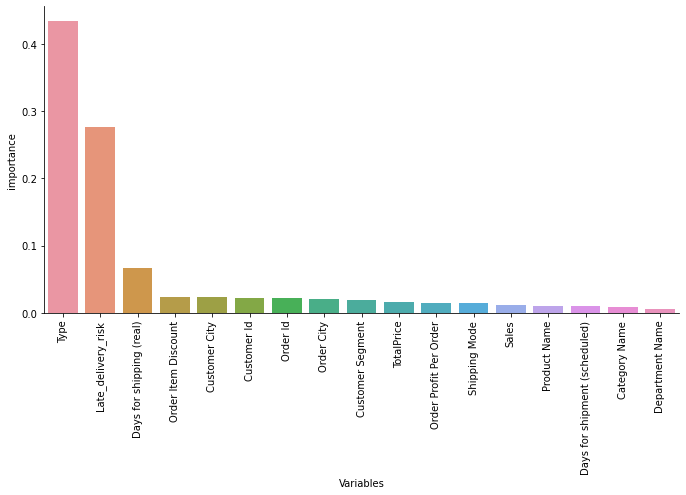

In [37]:
# Default Random Forest Model

D_RF_model = RandomForestClassifier()
t0=time()
D_RF_model=D_RF_model.fit(x_train,y_train)
print("Training time  :",round(time()-t0,3),"s")
t1=time()
D_RF_y_pred=D_RF_model.predict(x_test)
print("Prediction time:",round(time()-t1,3),"s")
D_RF_accuracy=accuracy_score(D_RF_y_pred, y_test) #Accuracy for fraud detection
D_RF_recall=recall_score(D_RF_y_pred, y_test) #Recall score for  fraud detection
D_RF_conf=confusion_matrix(y_test, D_RF_y_pred)# fraud detection
D_RF_f1=f1_score(y_test, D_RF_y_pred)#fraud detection
D_RF_auc=roc_auc_score(y_test,D_RF_y_pred)
D_RF_fpr,D_RF_tpr, _ =roc_curve(y_test,D_RF_y_pred)
print('Model paramters used are :',D_RF_model)
print('Accuracy:', (D_RF_accuracy)*100,'%')
print('Recall  :', (D_RF_recall)*100,'%')
print('F1      :', (D_RF_f1)*100,'%')
print('AUROC   :', (D_RF_auc)*100,'%')
print('Confusion matrix:')
print('TP: ', D_RF_conf[1, 1])
print('TN: ', D_RF_conf[0, 0])
print('FP: ', D_RF_conf[0, 1])
print('FN: ', D_RF_conf[1, 0],'\n')

# To print important features
featimp = pd.Series(D_RF_model.feature_importances_, index=list(x)).sort_values(ascending=False)
print('\n',featimp)

# Vizulization of important features
important_col=D_RF_model.feature_importances_.argsort()
feat_imp=pd.DataFrame({'Variables':x.columns[important_col],'importance':D_RF_model.feature_importances_[important_col]})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='Variables', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)


# LDA

In [27]:
# Parameter Tuning using RandomizedSearchCV for LDA

solver = ['svd','lsqr','eigen']
n_components = [1,2,3]
random_grid = {'solver': solver,
               'n_components': n_components
               }
pprint(random_grid)
model = LinearDiscriminantAnalysis()
rf_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=50, cv=3,
                               verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(x_train, y_train)
print(rf_random.best_params_)
print(rf_random.best_estimator_)
print(rf_random.best_score_)

{'n_components': [1, 2, 3], 'solver': ['svd', 'lsqr', 'eigen']}
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    5.4s finished


{'solver': 'svd', 'n_components': 1}
LinearDiscriminantAnalysis(n_components=1)
0.9214505423344667


Training time  : 0.925 s
Prediction time: 0.003 s
Model paramters used are : LinearDiscriminantAnalysis(n_components=1)
Accuracy: 84.43385774429426 %
Recall  : 12.814148309028855 %
F1      : 22.71727172717272 %
AUROC   : 92.03469584443563 %
Confusion matrix:
TP:  1239
TN:  44487
FP:  8430
FN:  0 

[ 2.67290598  1.70230061 -0.37586938 -3.57203106 -0.03072808  0.00560806
  0.04890961 -0.09452625 -0.02095983 -0.06529839 -0.03651673 -0.01101837
 -0.04926245  0.03317667 -0.03725327 -1.28382929 -0.05465453]
Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Late_delivery_risk', 'Category Name', 'Customer City', 'Customer Id',
       'Customer Segment', 'Department Name', 'Order City', 'Order Id',
       'Order Item Discount', 'Sales', 'Order Profit Per Order',
       'Product Name', 'Shipping Mode', 'TotalPrice'],
      dtype='object')


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

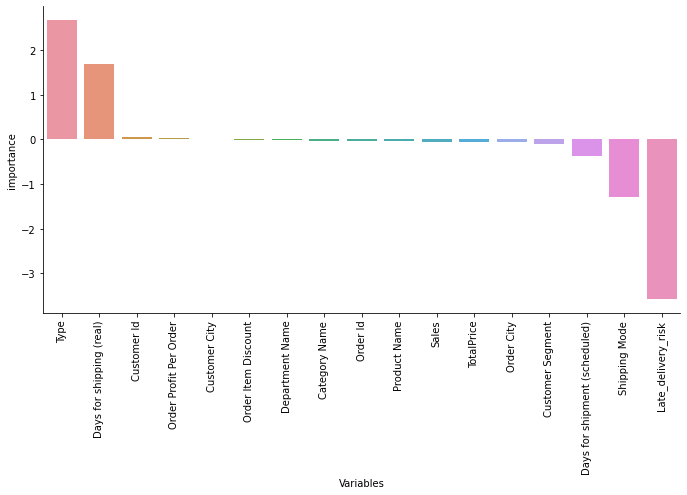

In [38]:
# Tuned LDA Model

H_LDA_model = LinearDiscriminantAnalysis(solver='svd', n_components=1)
t0=time()
H_LDA_model=H_LDA_model.fit(x_train,y_train)
print("Training time  :",round(time()-t0,3),"s")
t1=time()
H_LDA_y_pred=H_LDA_model.predict(x_test)
print("Prediction time:",round(time()-t1,3),"s")
H_LDA_accuracy=accuracy_score(H_LDA_y_pred, y_test) #Accuracy for fraud detection
H_LDA_recall=recall_score(H_LDA_y_pred, y_test) #Recall score for  fraud detection
H_LDA_y_conf=confusion_matrix(y_test, H_LDA_y_pred)# fraud detection
H_LDA_f1=f1_score(y_test, H_LDA_y_pred)#fraud detection
H_LDA_auc=roc_auc_score(y_test,H_LDA_y_pred)
H_LDA_fpr,H_LDA_tpr, _ =roc_curve(y_test,H_LDA_y_pred)
print('Model paramters used are :',H_LDA_model)
print('Accuracy:', (H_LDA_accuracy)*100,'%')
print('Recall  :', (H_LDA_recall)*100,'%')
print('F1      :', (H_LDA_f1)*100,'%')
print('AUROC   :', (H_LDA_auc)*100,'%')
print('Confusion matrix:')
print('TP: ', H_LDA_y_conf[1, 1])
print('TN: ', H_LDA_y_conf[0, 0])
print('FP: ', H_LDA_y_conf[0, 1])
print('FN: ', H_LDA_y_conf[1, 0],'\n')

s=H_LDA_model.coef_
list1 = s.tolist()
c = s.flatten()
print(c)
print(x.columns)

important_col=c.argsort()
feat_imp=pd.DataFrame({'Variables':x.columns,'importance':c})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='Variables', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)



# AdaBoost

In [28]:
# Parameter Tuning using RandomizedSearchCV fro AdaBoost

n_estimators = [100, 200, 300, 400, 500]
random_grid = {'n_estimators': n_estimators}
pprint(random_grid)
model = AdaBoostClassifier()
rf_random = RandomizedSearchCV(estimator=model, scoring='accuracy', param_distributions=random_grid, n_iter=50, cv=3,
                               verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(x_train, y_train)
print(rf_random.best_params_)
print(rf_random.best_estimator_)
print(rf_random.best_score_)

{'n_estimators': [100, 200, 300, 400, 500]}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  8.4min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 30.8min finished


{'n_estimators': 500}
AdaBoostClassifier(n_estimators=500)
0.9605755220981059


Training time  : 418.757 s
Prediction time: 8.489 s
Model paramters used are : AdaBoostClassifier(n_estimators=500)
Accuracy: 93.23066696210947 %
Recall  : 21.903218337578142 %
F1      : 34.04102195034184 %
AUROC   : 84.98888180727633 %
Confusion matrix:
TP:  946
TN:  49544
FP:  3373
FN:  293 


 Days for shipping (real)         0.264
Sales                            0.196
Customer Segment                 0.142
Customer City                    0.076
Department Name                  0.074
Product Name                     0.066
Days for shipment (scheduled)    0.042
Order City                       0.024
TotalPrice                       0.022
Order Item Discount              0.020
Order Id                         0.018
Category Name                    0.018
Shipping Mode                    0.016
Customer Id                      0.010
Order Profit Per Order           0.008
Late_delivery_risk               0.002
Type                             0.002
dtype: float64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

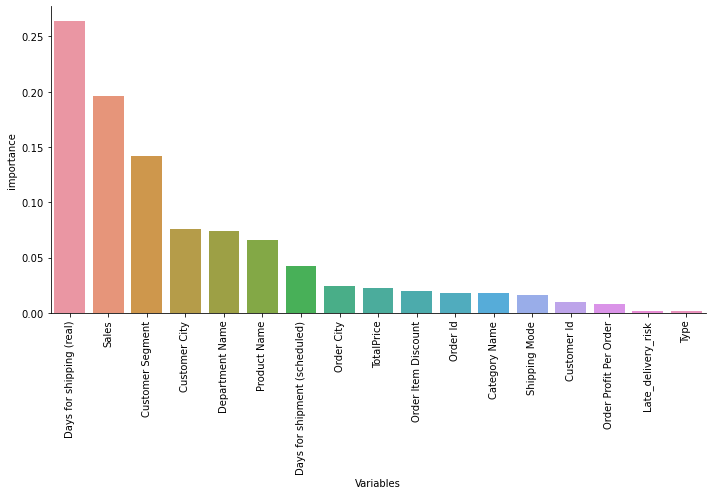

In [40]:
# Tuned AdaBoost Model

H_Ada_model = AdaBoostClassifier(n_estimators=500) 
t0=time()
H_Ada_model=H_Ada_model.fit(x_train,y_train)
print("Training time  :",round(time()-t0,3),"s")
t1=time()
H_Ada_y_pred=H_Ada_model.predict(x_test)
print("Prediction time:",round(time()-t1,3),"s")
H_Ada_accuracy=accuracy_score(H_Ada_y_pred, y_test) #Accuracy for fraud detection
H_Ada_recall=recall_score(H_Ada_y_pred, y_test) #Recall score for  fraud detection
H_Ada_conf=confusion_matrix(y_test, H_Ada_y_pred)# fraud detection
H_Ada_f1=f1_score(y_test, H_Ada_y_pred)#fraud detection
H_Ada_auc=roc_auc_score(y_test,H_Ada_y_pred)
H_Ada_fpr,H_Ada_tpr, _ =roc_curve(y_test,H_Ada_y_pred)
print('Model paramters used are :',H_Ada_model)
print('Accuracy:', (H_Ada_accuracy)*100,'%')
print('Recall  :', (H_Ada_recall)*100,'%')
print('F1      :', (H_Ada_f1)*100,'%')
print('AUROC   :', (H_Ada_auc)*100,'%')
print('Confusion matrix:')
print('TP: ', H_Ada_conf[1, 1])
print('TN: ', H_Ada_conf[0, 0])
print('FP: ', H_Ada_conf[0, 1])
print('FN: ', H_Ada_conf[1, 0],'\n')
#to print important features
featimp = pd.Series(H_Ada_model.feature_importances_, index=list(x)).sort_values(ascending=False)
print('\n',featimp)
#vizulization of important features
important_col=H_Ada_model.feature_importances_.argsort()
feat_imp=pd.DataFrame({'Variables':x.columns[important_col],'importance':H_Ada_model.feature_importances_[important_col]})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='Variables', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)

Training time  : 32.507 s
Prediction time: 0.901 s
Model paramters used are : AdaBoostClassifier()
Accuracy: 89.66319521382673 %
Recall  : 17.47500373078645 %
F1      : 29.496221662468514 %
AUROC   : 92.03068755716441 %
Confusion matrix:
TP:  1171
TN:  47387
FP:  5530
FN:  68 


 Days for shipping (real)         0.56
Customer Segment                 0.20
Customer City                    0.06
TotalPrice                       0.02
Shipping Mode                    0.02
Days for shipment (scheduled)    0.02
Late_delivery_risk               0.02
Customer Id                      0.02
Type                             0.02
Order Id                         0.02
Order Item Discount              0.02
Sales                            0.02
Order City                       0.00
Category Name                    0.00
Order Profit Per Order           0.00
Product Name                     0.00
Department Name                  0.00
dtype: float64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

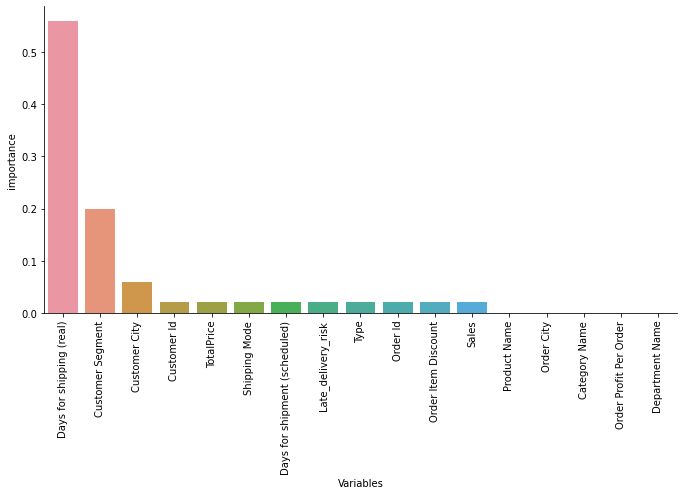

In [41]:
# Untuned AdaBoost Model

D_Ada_model = AdaBoostClassifier() 
t0=time()
D_Ada_model=D_Ada_model.fit(x_train,y_train)
print("Training time  :",round(time()-t0,3),"s")
t1=time()
D_Ada_y_pred=D_Ada_model.predict(x_test)
print("Prediction time:",round(time()-t1,3),"s")
D_Ada_accuracy=accuracy_score(D_Ada_y_pred, y_test) #Accuracy for fraud detection
D_Ada_recall=recall_score(D_Ada_y_pred, y_test) #Recall score for  fraud detection
D_Ada_conf=confusion_matrix(y_test, D_Ada_y_pred)# fraud detection
D_Ada_f1=f1_score(y_test, D_Ada_y_pred)#fraud detection
D_Ada_auc=roc_auc_score(y_test,D_Ada_y_pred)
D_Ada_fpr,D_Ada_tpr, _ =roc_curve(y_test,D_Ada_y_pred)
print('Model paramters used are :',D_Ada_model)
print('Accuracy:', (D_Ada_accuracy)*100,'%')
print('Recall  :', (D_Ada_recall)*100,'%')
print('F1      :', (D_Ada_f1)*100,'%')
print('AUROC   :', (D_Ada_auc)*100,'%')
print('Confusion matrix:')
print('TP: ', D_Ada_conf[1, 1])
print('TN: ', D_Ada_conf[0, 0])
print('FP: ', D_Ada_conf[0, 1])
print('FN: ', D_Ada_conf[1, 0],'\n')
#to print important features
featimp = pd.Series(D_Ada_model.feature_importances_, index=list(x)).sort_values(ascending=False)
print('\n',featimp)
#vizulization of important features
important_col=D_Ada_model.feature_importances_.argsort()
feat_imp=pd.DataFrame({'Variables':x.columns[important_col],'importance':D_Ada_model.feature_importances_[important_col]})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='Variables', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)

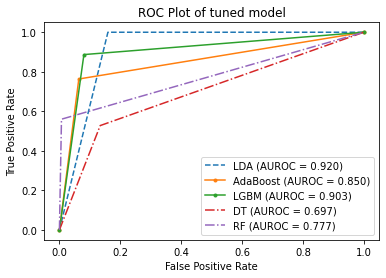

In [52]:
# ROC curve of Tuned Model

plt.plot(H_LDA_fpr, H_LDA_tpr, linestyle='--', label='LDA (AUROC = %.3f)' % H_LDA_auc)
plt.plot(H_Ada_fpr, H_Ada_tpr, marker='.', label='AdaBoost (AUROC = %0.3f)' % H_Ada_auc)
plt.plot(H_LGBM_fpr, H_LGBM_tpr, marker='.', label='LGBM (AUROC = %0.3f)' % H_LGBM_auc)
plt.plot(H_DT_fpr,H_DT_tpr, linestyle='-.',label='DT (AUROC = %0.3f)' % H_DT_auc)
plt.plot(H_RF_fpr,H_RF_tpr, linestyle='-.',label='RF (AUROC = %0.3f)' % H_RF_auc)

plt.title('ROC Plot of tuned model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() # 
plt.show()


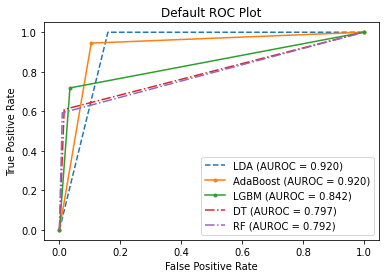

In [53]:
# ROC curve of Default Model

plt.plot(H_LDA_fpr, H_LDA_tpr, linestyle='--', label='LDA (AUROC = %.3f)' % H_LDA_auc)
plt.plot(D_Ada_fpr, D_Ada_tpr, marker='.', label='AdaBoost (AUROC = %0.3f)' % D_Ada_auc)
plt.plot(D_LGBM_fpr, D_LGBM_tpr, marker='.', label='LGBM (AUROC = %0.3f)' % D_LGBM_auc)
plt.plot(D_DT_fpr,D_DT_tpr, linestyle='-.',label='DT (AUROC = %0.3f)' % D_DT_auc)
plt.plot(D_RF_fpr,D_RF_tpr, linestyle='-.',label='RF (AUROC = %0.3f)' % D_RF_auc)


plt.title('Default ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


# Regression Modeling

In [87]:
dataset = S3_data

In [88]:
dataset.shape

(180519, 53)

In [89]:
# Dropping features whihch are not useful for Classification due to high co-relationship and repitative descriptive data values
data=dataset.drop(['Customer Email','Customer Password','Customer Street','Customer Fname','Customer Lname','Benefit per order',
                   'Sales per customer','Category Id','Customer Country','Customer State','Customer Zipcode','Department Id',
                   'Market','Order Country','Order Customer Id','order date (DateOrders)','Order Item Cardprod Id',
                   'Order Item Discount Rate','Order Item Id','Order Item Product Price','Order Item Profit Ratio',
                   'Order Item Quantity','Order Region','Order State','Order Status','Product Category Id',
                   'Product Card Id','Product Price','Delivery Status','Latitude','Longitude','Product Image','Order Zipcode',
                   'shipping date (DateOrders)','Product Status','Product Description'],axis=1)
data.shape

(180519, 17)

In [90]:
data.dtypes

Type                              object
Days for shipping (real)           int64
Days for shipment (scheduled)      int64
Late_delivery_risk                 int64
Category Name                     object
Customer City                     object
Customer Id                        int64
Customer Segment                  object
Department Name                   object
Order City                        object
Order Id                           int64
Order Item Discount              float64
Sales                            float64
Order Item Total                 float64
Order Profit Per Order           float64
Product Name                      object
Shipping Mode                     object
dtype: object

In [91]:
# Converting categorical values into numeric 
le = preprocessing.LabelEncoder()

data['Type']              = le.fit_transform(data['Type'])
data['Product Name']      = le.fit_transform(data['Product Name'])
data['Customer Segment']  = le.fit_transform(data['Customer Segment'])
data['Order City']        = le.fit_transform(data['Order City'])
data['Category Name']     = le.fit_transform(data['Category Name'])
data['Customer City']     = le.fit_transform(data['Customer City'])
data['Department Name']   = le.fit_transform(data['Department Name'])
data['Shipping Mode']     = le.fit_transform(data['Shipping Mode'])

data.head(3)

,Type,Days for shipping (real),Days for shipment (scheduled),Late_delivery_risk,Category Name,Customer City,Customer Id,Customer Segment,Department Name,Order City,Order Id,Order Item Discount,Sales,Order Item Total,Order Profit Per Order,Product Name,Shipping Mode
0,1,3,4,0,40,66,20755,0,4,331,77202,13.110000,327.75,314.640015,91.250000,78,3
1,3,5,4,1,40,66,19492,0,4,391,75939,16.389999,327.75,311.359985,-249.089996,78,3
2,0,4,4,0,40,452,19491,0,4,391,75938,18.030001,327.75,309.720001,-247.779999,78,3


In [92]:
data.dtypes

Type                               int32
Days for shipping (real)           int64
Days for shipment (scheduled)      int64
Late_delivery_risk                 int64
Category Name                      int32
Customer City                      int32
Customer Id                        int64
Customer Segment                   int32
Department Name                    int32
Order City                         int32
Order Id                           int64
Order Item Discount              float64
Sales                            float64
Order Item Total                 float64
Order Profit Per Order           float64
Product Name                       int32
Shipping Mode                      int32
dtype: object

In [93]:
x=data.loc[:, data.columns != 'Sales']
y=data['Sales']
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3, random_state = 42)

In [94]:
# Normalizing the data points so the average mean is 0 and Standard Deviation is 1
SSL = StandardScaler()
x_train=SSL.fit_transform(x_train)
x_test=SSL.transform(x_test)

# Gradient Boosted Tree

In [116]:
GBR_model = GradientBoostingRegressor()

In [117]:
    t0=time()
    GBR_model=GBR_model.fit(x_train,y_train)#Fitting train data for sales
    print("Training time  :",round(time()-t0,3),"s")
    t1=time()
    GBR_y_pred=GBR_model.predict(x_test)#predicting sales with test data
    print("Prediction time:",round(time()-t1,3),"s")
    print('Model parameter used are:',GBR_model) #Printing the model to see which parameters are used
    #Printing mean absolute error for predicting sales
    GBR_MAE=mean_absolute_error(y_test,GBR_y_pred)
    GBR_RMSE=np.sqrt(mean_squared_error(y_test,GBR_y_pred))
    GBR_MSE =mean_squared_error(y_test,GBR_y_pred)
    GBR_R2=r2_score(y_test,GBR_y_pred)
    print("MAE     :", GBR_MAE)
    print("RMSE    :",GBR_RMSE)
    print("MSE     :",GBR_MSE)
    print("R2_score:",GBR_R2)

Training time  : 37.993 s
Prediction time: 0.121 s
Model parameter used are: GradientBoostingRegressor()
MAE     : 1.8387701959755365
RMSE    : 3.1461471345100875
MSE     : 9.898241791986035
R2_score: 0.9994409823804102


                                Coefficient
Type                           0.000000e+00
Days for shipping (real)       0.000000e+00
Days for shipment (scheduled)  0.000000e+00
Late_delivery_risk             0.000000e+00
Category Name                  5.770506e-04
Customer City                  0.000000e+00
Customer Id                    4.493347e-05
Customer Segment               0.000000e+00
Department Name                2.942731e-04
Order City                     0.000000e+00
Order Id                       9.644345e-05
Order Item Discount            1.090935e-02
Order Item Total               9.878664e-01
Order Profit Per Order         3.887775e-07
Product Name                   2.111724e-04
Shipping Mode                  0.000000e+00


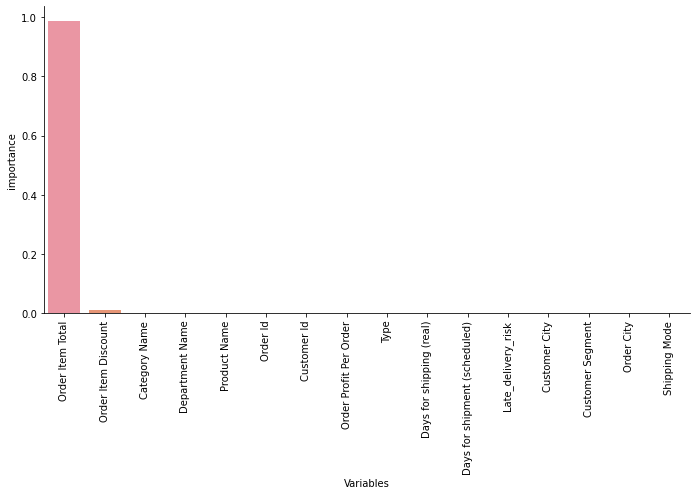

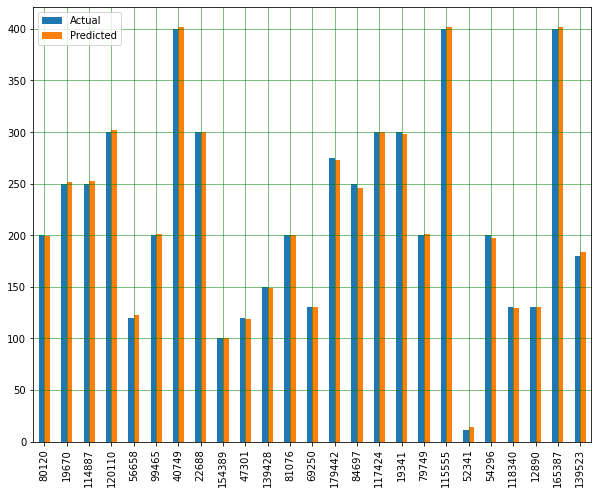

In [120]:
coeff_df = pd.DataFrame(GBR_model.feature_importances_, x.columns, columns=['Coefficient'])  
print(coeff_df)
s=GBR_model.feature_importances_
list1 = s.tolist()
c = s.flatten()

important_col=c.argsort()
feat_imp=pd.DataFrame({'Variables':x.columns,'importance':c})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='Variables', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)

df = pd.DataFrame({'Actual': y_test, 'Predicted': GBR_y_pred})
df1 = df.head(25)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

 # LASSO Model

In [97]:
Lasso_model = Lasso(alpha=0.1)

In [98]:
    t0=time()
    Lasso_model=Lasso_model.fit(x_train,y_train)#Fitting train data for sales
    print("Training time  :",round(time()-t0,3),"s")
    t1=time()
    L_y_pred=Lasso_model.predict(x_test)#predicting sales with test data
    print("Prediction time:",round(time()-t1,3),"s")
    print('Model parameter used are:',Lasso_model) #Printing the model to see which parameters are used
    #Printing mean absolute error for predicting sales
    Lasso_MAE=mean_absolute_error(y_test,L_y_pred)
    Lasso_RMSE=np.sqrt(mean_squared_error(y_test,L_y_pred))
    Lasso_MSE =mean_squared_error(y_test,L_y_pred)
    Lasso_R2 = r2_score(y_test,L_y_pred)
    print("MAE     :", Lasso_MAE)
    print("RMSE    :",Lasso_RMSE)
    print("MSE     :",Lasso_MSE)
    print("R2_score:",Lasso_R2)

Training time  : 0.044 s
Prediction time: 0.002 s
Model parameter used are: Lasso(alpha=0.1)
MAE     : 0.08339548200648535
RMSE    : 0.11536865510851727
MSE     : 0.013309926581548006
R2_score: 0.9999992483025136


                               Coefficient
Type                             -0.000000
Days for shipping (real)          0.000000
Days for shipment (scheduled)     0.000000
Late_delivery_risk               -0.000000
Category Name                    -0.000000
Customer City                     0.000000
Customer Id                       0.000000
Customer Segment                 -0.000000
Department Name                   0.000000
Order City                       -0.000000
Order Id                          0.000000
Order Item Discount              21.692465
Order Item Total                119.709004
Order Profit Per Order            0.000000
Product Name                     -0.000000
Shipping Mode                     0.000000


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

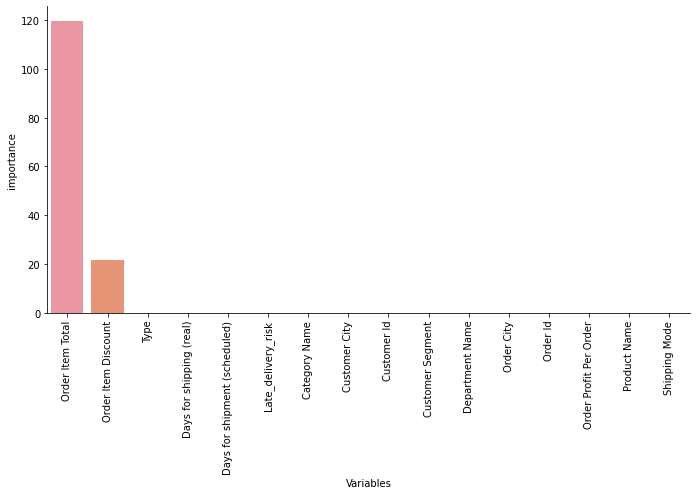

In [99]:
coeff_df = pd.DataFrame(Lasso_model.coef_, x.columns, columns=['Coefficient'])  
print(coeff_df)
s=Lasso_model.coef_
list1 = s.tolist()
c = s.flatten()

important_col=c.argsort()
feat_imp=pd.DataFrame({'Variables':x.columns,'importance':c})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='Variables', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)


# Ridge Model

In [125]:
Ridge_model = Ridge(alpha=1.0)

In [126]:
    t0=time()
    Ridge_model=Ridge_model.fit(x_train,y_train)#Fitting train data for sales
    print("Training time  :",round(time()-t0,3),"s")
    t1=time()
    R_y_pred=Ridge_model.predict(x_test)#predicting sales with test data
    print("Prediction time:",round(time()-t1,3),"s")
    print('Model parameter used are:',Ridge_model) #Printing the model to see which parameters are used
    #Printing mean absolute error for predicting sales
    Ridge_MAE=mean_absolute_error(y_test,R_y_pred)
    Ridge_RMSE=np.sqrt(mean_squared_error(y_test,R_y_pred))
    Ridge_MSE =mean_squared_error(y_test,R_y_pred)
    Ridge_R2  =r2_score(y_test,R_y_pred)
    print("MAE  :", Ridge_MAE)
    print("RMSE :",Ridge_RMSE)
    print("MSE  :",Ridge_MSE)
    print("R2   :",Ridge_R2)

Training time  : 0.064 s
Prediction time: 0.0 s
Model parameter used are: Ridge()
MAE  : 0.0010036470043190342
RMSE : 0.001882263872915812
MSE  : 3.5429172872840323e-06
R2   : 0.9999999997999086


                               Coefficient
Type                             -0.000007
Days for shipping (real)          0.000013
Days for shipment (scheduled)     0.000034
Late_delivery_risk               -0.000025
Category Name                    -0.000290
Customer City                    -0.000005
Customer Id                       0.000004
Customer Segment                 -0.000003
Department Name                   0.000173
Order City                       -0.000007
Order Id                          0.000057
Order Item Discount              21.756384
Order Item Total                119.776062
Order Profit Per Order            0.000123
Product Name                     -0.000363
Shipping Mode                    -0.000052


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

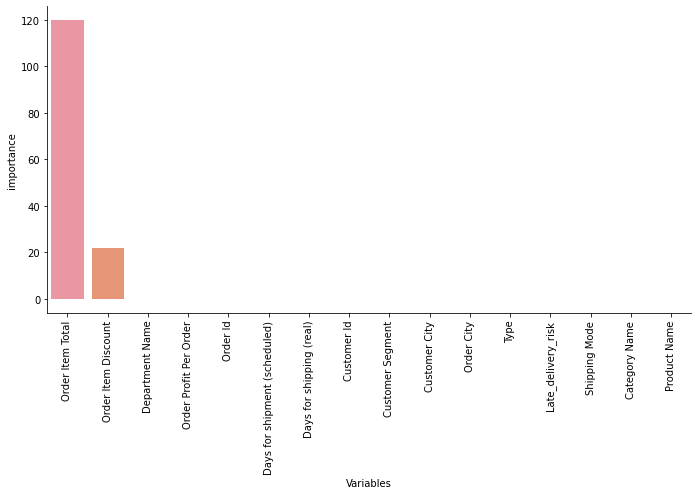

In [127]:
coeff_df = pd.DataFrame(Ridge_model.coef_, x.columns, columns=['Coefficient'])  
print(coeff_df)
s=Ridge_model.coef_
list1 = s.tolist()
c = s.flatten()

important_col=c.argsort()
feat_imp=pd.DataFrame({'Variables':x.columns,'importance':c})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='Variables', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)


# XGBoost Model

In [128]:
XG_model = xgb.XGBRegressor(alpha=4, colsample_bytree=0.7, max_depth=10, n_estimators=80,
             tree_method='auto')

In [130]:
    t0=time()
    XG_model=XG_model.fit(x_train,y_train)#Fitting train data for sales
    print("Training time  :",round(time()-t0,3),"s")
    t1=time()
    XG_y_pred=XG_model.predict(x_test)#predicting sales with test data
    print("Prediction time:",round(time()-t1,3),"s")
    print('Model parameter used are:',XG_model) #Printing the model to see which parameters are used
    #Printing mean absolute error for predicting sales
    XG_MAE=mean_absolute_error(y_test,XG_y_pred)
    XG_RMSE=np.sqrt(mean_squared_error(y_test,XG_y_pred))
    XG_MSE =mean_squared_error(y_test,XG_y_pred)
    XG_R2  =r2_score(y_test,XG_y_pred)
    print("MAE :", XG_MAE)
    print("RMSE:",XG_RMSE)
    print('MSE :',XG_MSE)
    print('R2  :',XG_R2)

[22:28:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training time  : 19.701 s
Prediction time: 0.763 s
Model parameter used are: XGBRegressor(alpha=4, colsample_bytree=0.7, max_depth=10, n_estimators=80,
             tree_method='auto')
MAE : 1.1313262058563323
RMSE: 4.793739223668036
MSE : 22.97993574453342
R2  : 0.9987021746641273


                               Coefficient
Type                              0.000044
Days for shipping (real)          0.000061
Days for shipment (scheduled)     0.000059
Late_delivery_risk                0.000120
Category Name                     0.016251
Customer City                     0.000101
Customer Id                       0.007763
Customer Segment                  0.000410
Department Name                   0.331833
Order City                        0.000152
Order Id                          0.003219
Order Item Discount               0.048776
Order Item Total                  0.318907
Order Profit Per Order            0.054082
Product Name                      0.218195
Shipping Mode                     0.000027


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

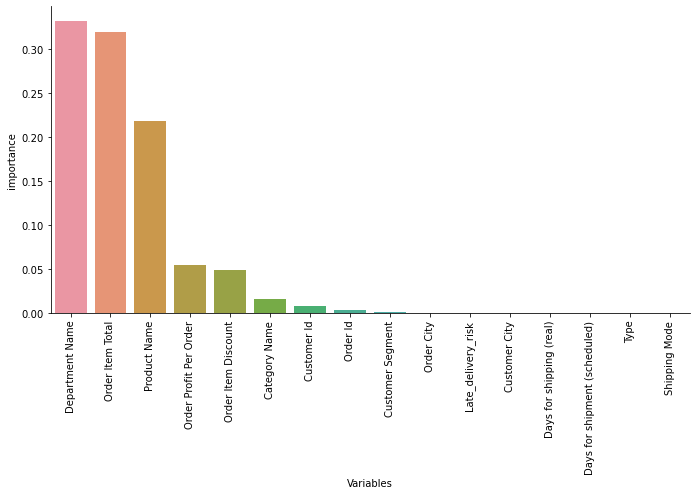

In [131]:
coeff_df = pd.DataFrame(XG_model.feature_importances_, x.columns, columns=['Coefficient'])  
print(coeff_df)
s=XG_model.feature_importances_
list1 = s.tolist()
c = s.flatten()

important_col=c.argsort()
feat_imp=pd.DataFrame({'Variables':x.columns,'importance':c})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='Variables', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)


# Linear Regression Model

In [132]:
LR_model = LinearRegression()

In [133]:
    t0=time()
    LR_model=LR_model.fit(x_train,y_train)#Fitting train data for sales
    print("Training time  :",round(time()-t0,3),"s")
    t1=time()
    LR_y_pred=LR_model.predict(x_test)#predicting sales with test data
    print("Prediction time:",round(time()-t1,3),"s")
    print('Model parameter used are:',LR_model) #Printing the model to see which parameters are used
    #Printing mean absolute error for predicting sales
    LR_MAE=mean_absolute_error(y_test,LR_y_pred)
    LR_RMSE=np.sqrt(mean_squared_error(y_test,LR_y_pred))
    LR_MSE = mean_squared_error(y_test,LR_y_pred)
    LR_R2 = r2_score(y_test,LR_y_pred)
    print("MAE :", LR_MAE)
    #Printing Root mean squared error for predicting sales
    print("RMSE:",LR_RMSE)
    print("MSE :",LR_MSE)
    print("R2  :",LR_R2)

Training time  : 0.088 s
Prediction time: 0.0 s
Model parameter used are: LinearRegression()
MAE : 0.0005448947680783427
RMSE: 0.0014938985645114012
MSE : 2.2317329210492254e-06
R2  : 0.9999999998739596


                                Coefficient
Type                          -9.191383e-06
Days for shipping (real)       5.547127e-06
Days for shipment (scheduled)  1.300954e-05
Late_delivery_risk            -1.457088e-05
Category Name                  7.296385e-05
Customer City                 -1.501646e-06
Customer Id                   -3.046989e-05
Customer Segment               2.204503e-06
Department Name                3.881403e-06
Order City                     4.880621e-07
Order Id                      -9.102988e-06
Order Item Discount            2.175604e+01
Order Item Total               1.197775e+02
Order Profit Per Order        -7.406012e-07
Product Name                   4.973923e-05
Shipping Mode                 -2.597093e-05


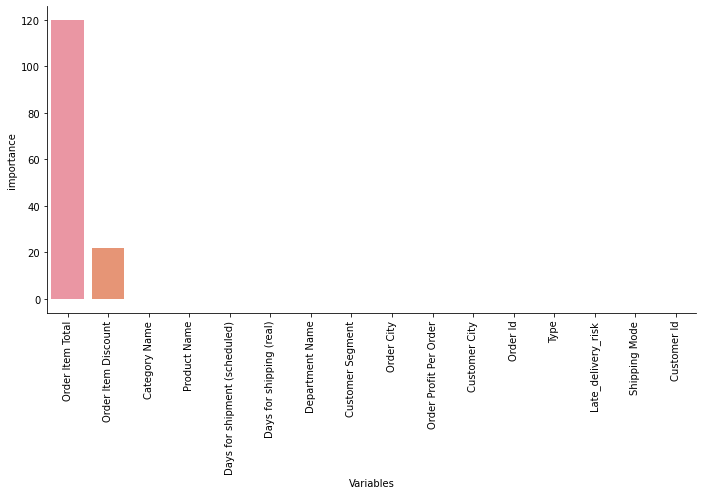

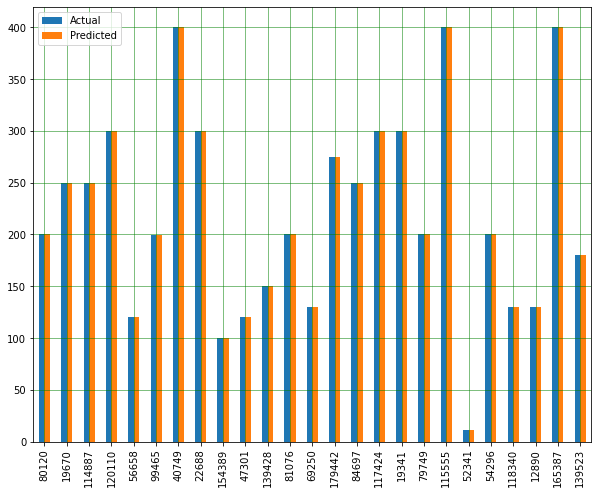

In [134]:
coeff_df = pd.DataFrame(LR_model.coef_, x.columns, columns=['Coefficient'])  
print(coeff_df)
s=LR_model.coef_
list1 = s.tolist()
c = s.flatten()

important_col=c.argsort()
feat_imp=pd.DataFrame({'Variables':x.columns,'importance':c})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='Variables', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)

df = pd.DataFrame({'Actual': y_test, 'Predicted': LR_y_pred})
df1 = df.head(25)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [135]:
# Plotting RMSE, MAE and MSE for all the models
X=['Lasso','Ridge','XG','LR','GBTR']
MAE=[Lasso_MAE,Ridge_MAE,XG_MAE,LR_MAE,GBR_MAE]
RMSE=[Lasso_RMSE,Ridge_RMSE,XG_RMSE,LR_RMSE,GBR_RMSE]
MSE=[Lasso_MSE,Ridge_MSE,XG_MSE,LR_MSE,GBR_MSE]

trace1 = go.Bar(
    x=X,
    y=MAE,
    name='MAE'
)
trace2 = go.Bar(
    x=X,
    y=RMSE,
    name='RMSE'
)

data = [trace1, trace2]
plotly.offline.iplot({
    "data": data,
    "layout": go.Layout(barmode='group', title="MAE vs RMSE"
                           ,width=800,height=500,)
})

trace3 = go.Bar(
    x=X,
    y=MSE,
    name='MSE'
)
data = [trace3]
plotly.offline.iplot({
    "data": data,
    "layout": go.Layout(barmode='group', title="MSE Plot"
                           ,width=800,height=500,)
})